## Question 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree,ensemble,cluster
from sklearn.metrics import accuracy_score,confusion_matrix,mean_squared_error,roc_auc_score,recall_score,precision_score
from datetime import timedelta
import datetime
import pytz
from sklearn import model_selection
import pickle
from math import sqrt

In [2]:
train=pd.read_csv('taxi-train.csv')

In [3]:
test=pd.read_csv('taxi-test.csv')

In [4]:
train.shape,test.shape

((1071910, 14), (10828, 11))

In [5]:
train['flag']=0
test['flag']=1
test['fare_amount']=1
test['tip_amount']=1
test['tip_paid']=20
data=train.append(test)

C:\Users\mdevasish\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [6]:
data.shape

(1082738, 15)

In [7]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
pickup_longitude,10828.0,-73.977155,0.014385,-73.999992,-73.988146,-73.979932,-73.968395,-73.901093
pickup_latitude,10828.0,40.756904,0.018265,40.700585,40.744828,40.757743,40.769749,40.799987
dropoff_longitude,10828.0,-73.975478,0.015812,-73.999988,-73.987152,-73.978599,-73.966107,-73.900187
dropoff_latitude,10828.0,40.757267,0.018781,40.700232,40.745697,40.758194,40.770290,40.799989
rate_code,9040.0,1.006416,0.137795,0.000000,1.000000,1.000000,1.000000,5.000000
passenger_count,10828.0,1.706779,1.326389,1.000000,1.000000,1.000000,2.000000,6.000000
trip_distance,10828.0,1.816876,1.256048,0.040000,0.940000,1.500000,2.300000,12.670000
flag,10828.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
fare_amount,10828.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
tip_amount,10828.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071910 entries, 0 to 1071909
Data columns (total 15 columns):
vendor_id            1071910 non-null object
pickup_datetime      1071910 non-null object
dropoff_datetime     1071910 non-null object
pickup_longitude     1071910 non-null float64
pickup_latitude      1071910 non-null float64
dropoff_longitude    1071910 non-null float64
dropoff_latitude     1071910 non-null float64
rate_code            898694 non-null float64
passenger_count      1071910 non-null int64
trip_distance        1071910 non-null float64
payment_type         1071910 non-null object
fare_amount          1071910 non-null float64
tip_amount           1071910 non-null float64
tip_paid             1071910 non-null int64
flag                 1071910 non-null int64
dtypes: float64(8), int64(3), object(4)
memory usage: 122.7+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10828 entries, 0 to 10827
Data columns (total 15 columns):
vendor_id            10828 non-null object
pickup_datetime      10828 non-null object
dropoff_datetime     10828 non-null object
pickup_longitude     10828 non-null float64
pickup_latitude      10828 non-null float64
dropoff_longitude    10828 non-null float64
dropoff_latitude     10828 non-null float64
rate_code            9040 non-null float64
passenger_count      10828 non-null int64
trip_distance        10828 non-null float64
payment_type         10828 non-null object
flag                 10828 non-null int64
fare_amount          10828 non-null int64
tip_amount           10828 non-null int64
tip_paid             10828 non-null int64
dtypes: float64(6), int64(5), object(4)
memory usage: 1.2+ MB


In [10]:
#Preprocessing for dates
# Derived duration, week day and new time as per time zone
data.pickup_datetime=pd.to_datetime(data.pickup_datetime)
data.dropoff_datetime=pd.to_datetime(data.dropoff_datetime)
data['pickup_datezone']=data['pickup_datetime'].apply(lambda x:x.astimezone('US/Eastern'))
data['dropoff_datezone']=data['dropoff_datetime'].apply(lambda x:x.astimezone('US/Eastern'))
data['duration']=data.dropoff_datetime-data.pickup_datetime
data['duration']=data['duration'].apply(lambda x: x.total_seconds())

# Cleaning the records with duration less than zero
#data=data[data['duration'] >0]
data['weekday']=data.pickup_datezone.dt.weekday
data['year']=data['pickup_datezone'].apply(lambda x:x.year)
data['hours']=data['pickup_datezone'].apply(lambda x:x.time().hour)
data['minutes']=data['pickup_datezone'].apply(lambda x:x.time().minute)
data['seconds']=data['pickup_datezone'].apply(lambda x:x.time().second)
year=pd.get_dummies(data['year'],prefix='year=')
data['sec_norm']=((data['hours']*60*60)+(data['minutes']*60)+data['seconds'])/86400
data=data.drop(['hours','minutes','seconds','pickup_datetime','dropoff_datetime','year',\
                  'pickup_datezone','dropoff_datezone'],axis=1)
#days=pd.get_dummies(data['weekday'],prefix='Day')
#hours=pd.get_dummies(data['hour'],prefix='Hour')


# Preprocessing for payment_type Recoding and Encoding
print(data.payment_type.unique())
data['payment_type'].replace('Cre','CRD',inplace=True)
data['payment_type'].replace('Cas','CSH',inplace=True)
data['payment_type'].replace('Dis','DIS',inplace=True)
data['payment_type'].replace('CRE','CRD',inplace=True)
data['payment_type'].replace('CAS','CSH',inplace=True)
data['payment_type'].replace('Dis','DIS',inplace=True)
data['payment_type'].replace('UNK','NA ',inplace=True)
data['payment_type'].replace('No ','UNK',inplace=True)
print('Unique payment methods\n',data.payment_type.unique())
print('Distribution of payment methods\n',data.payment_type.value_counts())
pay=pd.get_dummies(data['payment_type'], prefix='Pay')

#Ordinal encoding of passenger count
data['passenger_count_1'] = 1 * (data['passenger_count'] >= 1)
data['passenger_count_2'] = 1 * (data['passenger_count'] >= 2)
data['passenger_count_3'] = 1 * (data['passenger_count'] >= 3)
data['passenger_count_4'] = 1 * (data['passenger_count'] >= 4)
data['passenger_count_5'] = 1 * (data['passenger_count'] >= 5)

# Pre processing for rate_code
print(data.rate_code.value_counts())
data.rate_code=data.rate_code.fillna(100)
print(data.rate_code.unique())
rate=pd.get_dummies(data['rate_code'],prefix='rate')

# Concatenation for vendor ID, weekday and payment_type, passenger_count, rate_code 
vendor=pd.get_dummies(data['vendor_id'], prefix = 'vendorid')
days=pd.get_dummies(data['weekday'],prefix='Day')
pay=pd.get_dummies(data['payment_type'], prefix='Pay')

# Exploring feature cross between vendor and payment
data['fcross']=data.vendor_id+"_"+data.payment_type
fcross=pd.get_dummies(data['fcross'],prefix='cross')

# Co ordinates transformation
coords = np.vstack((data[['pickup_latitude', 'pickup_longitude']].values,
                    data[['dropoff_latitude', 'dropoff_longitude']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = cluster.MiniBatchKMeans(n_clusters=10, batch_size=100).fit(coords[sample_ind])

data.loc[:, 'pickup_cluster'] = kmeans.predict(data[['pickup_latitude', 'pickup_longitude']])
data.loc[:, 'dropoff_cluster'] = kmeans.predict(data[['dropoff_latitude', 'dropoff_longitude']])
#data=data.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1)

pickup=pd.get_dummies(data['pickup_cluster'],prefix='Pickcluster')
drop=pd.get_dummies(data['dropoff_cluster'],prefix='dropcluster')
data=pd.concat([data.drop(['payment_type','weekday','vendor_id','passenger_count','rate_code','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','fcross'],axis=1),rate,pay,days,vendor,year,pickup,drop,fcross],axis = 1)

print('No.of records with distance less than zero after cleaning',len(data[data.trip_distance < 0]))
# Cleaning the records with high duration. Setting max duration time as 3 hours
#data=data[data.duration<=10800]

['CSH' 'Cre' 'CRD' 'CAS' 'Cas' 'CRE' 'NOC' 'DIS' 'UNK' 'No ' 'Dis' 'NA ']
Unique payment methods
 ['CSH' 'CRD' 'NOC' 'DIS' 'NA ' 'UNK']
Distribution of payment methods
 CSH    611361
CRD    468702
NOC      1149
NA       1066
DIS       329
UNK       131
Name: payment_type, dtype: int64
1.0     905915
4.0       1169
2.0        385
0.0        119
5.0         88
3.0         52
6.0          5
99.0         1
Name: rate_code, dtype: int64
[  1. 100.   4.   2.   3.   0.   5.   6.  99.]
No.of records with distance less than zero after cleaning 0


In [11]:
train = data[data.flag == 0]
test = data[data.flag == 1]
train=train.drop(['flag'],axis=1)
test=test.drop(['flag'],axis=1)

In [12]:
print(train.shape, test.shape)
train=train[train['duration'] >0]
train=train[train.duration<=10800]
print(train.shape)

(1071910, 77) (10828, 77)
(1071165, 77)


In [13]:
test=test.drop(['fare_amount','tip_amount','tip_paid'],axis=1)

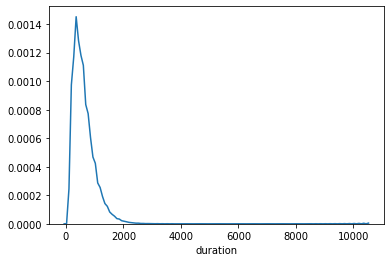

In [14]:
#train.drop(['hour'],axis=1)
sns.distplot(train.duration,hist=False)

In [15]:
train.columns

Index(['fare_amount', 'tip_amount', 'tip_paid', 'trip_distance', 'duration',
       'sec_norm', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'pickup_cluster', 'dropoff_cluster', 'rate_0.0', 'rate_1.0', 'rate_2.0',
       'rate_3.0', 'rate_4.0', 'rate_5.0', 'rate_6.0', 'rate_99.0',
       'rate_100.0', 'Pay_CRD', 'Pay_CSH', 'Pay_DIS', 'Pay_NA ', 'Pay_NOC',
       'Pay_UNK', 'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5',
       'Day_6', 'vendorid_CMT', 'vendorid_DDS', 'vendorid_VTS', 'year=_2008',
       'year=_2009', 'year=_2010', 'year=_2011', 'year=_2012', 'year=_2013',
       'year=_2014', 'year=_2015', 'Pickcluster_0', 'Pickcluster_1',
       'Pickcluster_2', 'Pickcluster_3', 'Pickcluster_4', 'Pickcluster_5',
       'Pickcluster_6', 'Pickcluster_7', 'Pickcluster_8', 'Pickcluster_9',
       'dropcluster_0', 'dropcluster_1', 'dropcluster_2', 'dropcluster_3',
       'dropcluster_4', 'dropcluster_5', 'dropc

## Base Model for fare with default parameters

In [16]:
# Model building for Fare amount
data=train[['trip_distance','duration','sec_norm',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'rate_0.0', 'rate_1.0',
       'rate_2.0', 'rate_3.0', 'rate_4.0', 'rate_5.0', 'rate_6.0', 'rate_99.0',
       'rate_100.0', 'Pay_CRD', 'Pay_CSH', 'Pay_DIS', 'Pay_NA ', 'Pay_NOC',
       'Pay_UNK', 'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5',
       'Day_6', 'vendorid_CMT', 'vendorid_DDS', 'vendorid_VTS', 'year=_2008',
       'year=_2009', 'year=_2010', 'year=_2011', 'year=_2012', 'year=_2013',
       'year=_2014', 'year=_2015', 'Pickcluster_0', 'Pickcluster_1',
       'Pickcluster_2', 'Pickcluster_3', 'Pickcluster_4', 'Pickcluster_5',
       'Pickcluster_6', 'Pickcluster_7', 'Pickcluster_8', 'Pickcluster_9',
       'dropcluster_0', 'dropcluster_1', 'dropcluster_2', 'dropcluster_3',
       'dropcluster_4', 'dropcluster_5', 'dropcluster_6', 'dropcluster_7',
       'dropcluster_8', 'dropcluster_9','cross_CMT_CRD', 'cross_CMT_CSH',
       'cross_CMT_DIS', 'cross_CMT_NA ', 'cross_CMT_NOC', 'cross_CMT_UNK',
       'cross_DDS_CRD', 'cross_DDS_CSH', 'cross_VTS_CRD', 'cross_VTS_CSH',
       'cross_VTS_NA ']].values
y_fare=train[['fare_amount']].values

x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_fare, test_size = 0.2, random_state = 2019)
dt_reg_estimator = tree.DecisionTreeRegressor()
dt_reg_estimator.fit(x_train, y_train)
y_fare_pred=dt_reg_estimator.predict(x_train)
print('Metrics for Regression tree: ')
print('MSE on train data : {}'.format(mean_squared_error(y_train, y_fare_pred)))

y_fare_pred_test=dt_reg_estimator.predict(x_test)
print('MSE on test data : {}'.format(mean_squared_error(y_test, y_fare_pred_test)))

Metrics for Regression tree: 
MSE on train data : 5.455508721812232e-06
MSE on test data : 1.4977664239402895


Mean Square error approximately = 0 on training set. This is a sign of overfitting.

## Base model for tip amount with default parameters

In [17]:
y_tipamount=train[['tip_amount']].values
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_tipamount, test_size = 0.2, 
                                                                    random_state = 2019)
dt_reg_estimator.fit(x_train, y_train)
y_tipamount_pred=dt_reg_estimator.predict(x_train)
print('MSE on training set : {}'.format(mean_squared_error(y_train, y_tipamount_pred)))

y_tipamount_pred_test=dt_reg_estimator.predict(x_test)
print('MSE on test set : {}'.format(mean_squared_error(y_test, y_tipamount_pred_test)))

MSE on training set : 1.8115498079194146e-05
MSE on test set : 1.0398325445893022


Mean Square error approximately = 0 on training set. This is sign of overfitting

## Base model for tip paid with default parameters

In [18]:
y_tip_paid=train[['tip_paid']].values
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_tip_paid, test_size = 0.2, 
                                                                    random_state = 2019)
dt_estimator=tree.DecisionTreeClassifier()
dt_estimator.fit(x_train,y_train)
y_tip_paid_pred=dt_estimator.predict(x_train)

print('Accuracy on training set: {}'.format(accuracy_score(y_train, y_tip_paid_pred)))
print('Confusion Matrix on training set: {}\n'.format(confusion_matrix(y_train, y_tip_paid_pred)))
print('Area under the curve for test set: {}'.format(roc_auc_score(y_train, y_tip_paid_pred)))
print('Recall score for training set: {}'.format(recall_score(y_train, y_tip_paid_pred)))
print('Precision score for training set: {}'.format(precision_score(y_train, y_tip_paid_pred)))

y_tip_paid_pred_test=dt_estimator.predict(x_test)
print('Accuracy on test set: {}'.format(accuracy_score(y_test, y_tip_paid_pred_test)))
print('Confusion Matrix on test set: {}\n'.format(confusion_matrix(y_test,y_tip_paid_pred_test)))
print('Area under the curve for test set: {}'.format(roc_auc_score(y_test, y_tip_paid_pred_test)))
print('Recall score for test set: {}'.format(recall_score(y_test, y_tip_paid_pred_test)))
print('Precision score for test set: {}'.format(precision_score(y_test, y_tip_paid_pred_test)))

Accuracy on training set: 0.9999976660925254
Confusion Matrix on training set: [[494696      0]
 [     2 362234]]

Area under the curve for test set: 0.9999972393688092
Recall score for training set: 0.9999944787376186
Precision score for training set: 1.0
Accuracy on test set: 0.974905826833401
Confusion Matrix on test set: [[121179   2343]
 [  3033  87678]]

Area under the curve for test set: 0.9737979311570906
Recall score for test set: 0.9665641432681814
Precision score for test set: 0.9739727396940714


Accuracy = 1 on training data. This is a sign of overfitting.

## Manual Hyper parametertuning (Max depth and min_samples_leaf) for fare amount 

In [19]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_fare, test_size = 0.2, 
                                                                    random_state = 2019)

dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 7,min_samples_leaf = 7)
dt_reg_estimator.fit(x_train, y_train)
y_fare_pred=dt_reg_estimator.predict(x_train)
y_fare_pred_pred=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 7 and min samples in the leaf = 7: {}'
      .format(sqrt(mean_squared_error(y_train, y_fare_pred))))
print('Test set')
print('RMSE for depth of depth = 7 and min samples in the leaf = 7: {}'
      .format(sqrt(mean_squared_error(y_test, y_fare_pred_test))))

dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 7,min_samples_leaf = 3)
dt_reg_estimator.fit(x_train, y_train)
y_fare_pred=dt_reg_estimator.predict(x_train)
y_fare_pred_pred=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 7 and min samples in the leaf = 5: {}'
      .format(sqrt(mean_squared_error(y_train, y_fare_pred))))
print('Test set')
print('RMSE for depth of depth = 7 and min samples in the leaf = 5: {}'
      .format(sqrt(mean_squared_error(y_test, y_fare_pred_test))))

dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 7,min_samples_leaf = 3)
dt_reg_estimator.fit(x_train, y_train)
y_fare_pred=dt_reg_estimator.predict(x_train)
y_fare_pred_pred=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 7 and min samples in the leaf = 3: {}'
      .format(sqrt(mean_squared_error(y_train, y_fare_pred))))
print('Test set')
print('RMSE for depth of depth = 7 and min samples in the leaf = 3: {}'
      .format(sqrt(mean_squared_error(y_test, y_fare_pred_test))))

dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 5,min_samples_leaf = 7)
dt_reg_estimator.fit(x_train, y_train)
y_fare_pred=dt_reg_estimator.predict(x_train)
y_fare_pred_pred=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 5 and min samples in the leaf = 7: {}'
      .format(sqrt(mean_squared_error(y_train, y_fare_pred))))
print('Test set')
print('RMSE for depth of depth = 5 and min samples in the leaf = 7: {}'
      .format(sqrt(mean_squared_error(y_test, y_fare_pred_test))))

dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 5,min_samples_leaf = 5)
dt_reg_estimator.fit(x_train, y_train)
y_fare_pred=dt_reg_estimator.predict(x_train)
y_fare_pred_pred=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 5 and min samples in the leaf = 5: {}'
      .format(sqrt(mean_squared_error(y_train, y_fare_pred))))
print('Test set')
print('RMSE for depth of depth = 5 and min samples in the leaf = 5: {}'
      .format(sqrt(mean_squared_error(y_test, y_fare_pred_test))))


dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 5,min_samples_leaf = 3)
dt_reg_estimator.fit(x_train, y_train)
y_fare_pred=dt_reg_estimator.predict(x_train)
y_fare_pred_pred=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 5 and min samples in the leaf = 3: {}'
      .format(sqrt(mean_squared_error(y_train, y_fare_pred))))
print('Test set')
print('RMSE for depth of depth = 5 and min samples in the leaf = 3: {}'
      .format(sqrt(mean_squared_error(y_test, y_fare_pred_test))))

dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 3,min_samples_leaf = 7)
dt_reg_estimator.fit(x_train, y_train)
y_fare_pred=dt_reg_estimator.predict(x_train)
y_fare_pred_pred=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 3 and min samples in the leaf = 7: {}'
      .format(sqrt(mean_squared_error(y_train, y_fare_pred))))
print('Test set')
print('RMSE for depth of depth = 3 and min samples in the leaf = 7: {}'
      .format(sqrt(mean_squared_error(y_test, y_fare_pred_test))))


dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 3,min_samples_leaf = 5)
dt_reg_estimator.fit(x_train, y_train)
y_fare_pred=dt_reg_estimator.predict(x_train)
y_fare_pred_pred=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 3 and min samples in the leaf = 5: {}'
      .format(sqrt(mean_squared_error(y_train, y_fare_pred))))
print('Test set')
print('RMSE for depth of depth = 3 and min samples in the leaf = 5: {}'
      .format(sqrt(mean_squared_error(y_test, y_fare_pred_test))))


dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 3,min_samples_leaf = 3)
dt_reg_estimator.fit(x_train, y_train)
y_fare_pred=dt_reg_estimator.predict(x_train)
y_fare_pred_pred=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 3 and min samples in the leaf = 3: {}'
      .format(sqrt(mean_squared_error(y_train, y_fare_pred))))
print('Test set')
print('RMSE for depth of depth = 3 and min samples in the leaf = 3: {}'
      .format(sqrt(mean_squared_error(y_test, y_fare_pred_test))))


Training set
RMSE for depth of depth = 7 and min samples in the leaf = 7: 1.1608923125509107
Test set
RMSE for depth of depth = 7 and min samples in the leaf = 7: 1.2238326780815625
Training set
RMSE for depth of depth = 7 and min samples in the leaf = 5: 1.1521129891381918
Test set
RMSE for depth of depth = 7 and min samples in the leaf = 5: 1.2238326780815625
Training set
RMSE for depth of depth = 7 and min samples in the leaf = 3: 1.1521129891381918
Test set
RMSE for depth of depth = 7 and min samples in the leaf = 3: 1.2238326780815625
Training set
RMSE for depth of depth = 5 and min samples in the leaf = 7: 1.382306076431375
Test set
RMSE for depth of depth = 5 and min samples in the leaf = 7: 1.2238326780815625
Training set
RMSE for depth of depth = 5 and min samples in the leaf = 5: 1.382306076431375
Test set
RMSE for depth of depth = 5 and min samples in the leaf = 5: 1.2238326780815625
Training set
RMSE for depth of depth = 5 and min samples in the leaf = 3: 1.3823060764313748

## Manual Hyper parametertuning (Max depth and min_samples_leaf) for tip amount 

In [20]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_tipamount, test_size = 0.2, 
                                                                    random_state = 2019)

dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 7,min_samples_leaf = 7)
dt_reg_estimator.fit(x_train, y_train)
y_tip_pred=dt_reg_estimator.predict(x_train)
y_tip_pred_test=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 7 and min samples in the leaf = 7: {}'
      .format(sqrt(mean_squared_error(y_train, y_tip_pred))))
print('Test set')
print('RMSE for depth of depth = 7 and min samples in the leaf = 7: {}'
      .format(sqrt(mean_squared_error(y_test, y_tip_pred_test))))

dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 7,min_samples_leaf = 3)
dt_reg_estimator.fit(x_train, y_train)
y_tip_pred=dt_reg_estimator.predict(x_train)
y_tip_pred_test=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 7 and min samples in the leaf = 5: {}'
      .format(sqrt(mean_squared_error(y_train, y_tip_pred))))
print('Test set')
print('RMSE for depth of depth = 7 and min samples in the leaf = 5: {}'
      .format(sqrt(mean_squared_error(y_test, y_tip_pred_test))))

dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 7,min_samples_leaf = 3)
dt_reg_estimator.fit(x_train, y_train)
y_tip_pred=dt_reg_estimator.predict(x_train)
y_tip_pred_test=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 7 and min samples in the leaf = 3: {}'
      .format(sqrt(mean_squared_error(y_train, y_tip_pred))))
print('Test set')
print('RMSE for depth of depth = 7 and min samples in the leaf = 3: {}'
      .format(sqrt(mean_squared_error(y_test, y_tip_pred_test))))

dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 5,min_samples_leaf = 7)
dt_reg_estimator.fit(x_train, y_train)
y_tip_pred=dt_reg_estimator.predict(x_train)
y_tip_pred_test=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 5 and min samples in the leaf = 7: {}'
      .format(sqrt(mean_squared_error(y_train, y_tip_pred))))
print('Test set')
print('RMSE for depth of depth = 5 and min samples in the leaf = 7: {}'
      .format(sqrt(mean_squared_error(y_test, y_tip_pred_test))))

dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 5,min_samples_leaf = 5)
dt_reg_estimator.fit(x_train, y_train)
y_tip_pred=dt_reg_estimator.predict(x_train)
y_tip_pred_test=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 5 and min samples in the leaf = 5: {}'
      .format(sqrt(mean_squared_error(y_train, y_tip_pred))))
print('Test set')
print('RMSE for depth of depth = 5 and min samples in the leaf = 5: {}'
      .format(sqrt(mean_squared_error(y_test, y_tip_pred_test))))


dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 5,min_samples_leaf = 3)
dt_reg_estimator.fit(x_train, y_train)
y_tip_pred=dt_reg_estimator.predict(x_train)
y_tip_pred_test=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 5 and min samples in the leaf = 3: {}'
      .format(sqrt(mean_squared_error(y_train, y_tip_pred))))
print('Test set')
print('RMSE for depth of depth = 5 and min samples in the leaf = 3: {}'
      .format(sqrt(mean_squared_error(y_test, y_tip_pred_test))))

dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 3,min_samples_leaf = 7)
dt_reg_estimator.fit(x_train, y_train)
y_tip_pred=dt_reg_estimator.predict(x_train)
y_tip_pred_test=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 3 and min samples in the leaf = 7: {}'
      .format(sqrt(mean_squared_error(y_train, y_tip_pred))))
print('Test set')
print('RMSE for depth of depth = 3 and min samples in the leaf = 7: {}'
      .format(sqrt(mean_squared_error(y_test, y_tip_pred_test))))


dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 3,min_samples_leaf = 5)
dt_reg_estimator.fit(x_train, y_train)
y_tip_pred=dt_reg_estimator.predict(x_train)
y_tip_pred_test=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 3 and min samples in the leaf = 5: {}'
      .format(sqrt(mean_squared_error(y_train, y_tip_pred))))
print('Test set')
print('RMSE for depth of depth = 3 and min samples in the leaf = 5: {}'
      .format(sqrt(mean_squared_error(y_test, y_tip_pred_test))))


dt_reg_estimator = tree.DecisionTreeRegressor(max_depth = 3,min_samples_leaf = 3)
dt_reg_estimator.fit(x_train, y_train)
y_tip_pred=dt_reg_estimator.predict(x_train)
y_tip_pred_test=dt_reg_estimator.predict(x_test)
print('Training set')
print('RMSE for depth of depth = 3 and min samples in the leaf = 3: {}'
      .format(sqrt(mean_squared_error(y_train, y_tip_pred))))
print('Test set')
print('RMSE for depth of depth = 3 and min samples in the leaf = 3: {}'
      .format(sqrt(mean_squared_error(y_test, y_tip_pred_test))))


Training set
RMSE for depth of depth = 7 and min samples in the leaf = 7: 0.6504805245049889
Test set
RMSE for depth of depth = 7 and min samples in the leaf = 7: 0.7578377996048383
Training set
RMSE for depth of depth = 7 and min samples in the leaf = 5: 0.6491618697809148
Test set
RMSE for depth of depth = 7 and min samples in the leaf = 5: 0.7593968075137407
Training set
RMSE for depth of depth = 7 and min samples in the leaf = 3: 0.6491618697809148
Test set
RMSE for depth of depth = 7 and min samples in the leaf = 3: 0.7593971489992353
Training set
RMSE for depth of depth = 5 and min samples in the leaf = 7: 0.6596162680388729
Test set
RMSE for depth of depth = 5 and min samples in the leaf = 7: 0.7625468062373366
Training set
RMSE for depth of depth = 5 and min samples in the leaf = 5: 0.6596126537331908
Test set
RMSE for depth of depth = 5 and min samples in the leaf = 5: 0.7625457072494524
Training set
RMSE for depth of depth = 5 and min samples in the leaf = 3: 0.65960224805907

## Manual Hyper parametertuning (criterion and depth of the tree) for tip paid

In [21]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_tip_paid, test_size = 0.2, 
                                                                    random_state = 2019)

dt_estimator=tree.DecisionTreeClassifier(criterion="entropy",max_depth=3)
dt_estimator.fit(x_train,y_train)
y_tip_paid_pred=dt_estimator.predict(x_train)
y_tip_paid_pred_test=dt_estimator.predict(x_test)
print('\nCriterion=entropy and max_depth=3')
print('Training set')
print('Accuracy: {}'.format(accuracy_score(y_train, y_tip_paid_pred)))
print('Area under the curve for test set: {}'.format(roc_auc_score(y_train, y_tip_paid_pred)))
print('Recall score for training set: {}'.format(recall_score(y_train, y_tip_paid_pred)))
print('Precision score for training set: {}'.format(precision_score(y_train, y_tip_paid_pred)))


dt_estimator=tree.DecisionTreeClassifier(criterion="entropy",max_depth=5)
dt_estimator.fit(x_train,y_train)
y_tip_paid_pred=dt_estimator.predict(x_train)
y_tip_paid_pred_test=dt_estimator.predict(x_test)
print('\nCriterion=entropy and max_depth=5')
print('Training set')
print('Accuracy: {}'.format(accuracy_score(y_train, y_tip_paid_pred)))
print('Area under the curve for test set: {}'.format(roc_auc_score(y_train, y_tip_paid_pred)))
print('Recall score for training set: {}'.format(recall_score(y_train, y_tip_paid_pred)))
print('Precision score for training set: {}'.format(precision_score(y_train, y_tip_paid_pred)))

print('Test set')
print('Accuracy: {}'.format(accuracy_score(y_test, y_tip_paid_pred_test)))
print('Area under the curve for test set: {}'.format(roc_auc_score(y_test, y_tip_paid_pred_test)))
print('Recall score for test set: {}'.format(recall_score(y_test, y_tip_paid_pred_test)))
print('Precision score for test set: {}'.format(precision_score(y_test, y_tip_paid_pred_test)))

dt_estimator=tree.DecisionTreeClassifier(criterion="entropy",max_depth=7)
dt_estimator.fit(x_train,y_train)
y_tip_paid_pred=dt_estimator.predict(x_train)
y_tip_paid_pred_test=dt_estimator.predict(x_test)
print('\nCriterion=entropy and max_depth=7\n')
print('Training set')
print('Accuracy: {}'.format(accuracy_score(y_train, y_tip_paid_pred)))
print('Area under the curve for test set: {}'.format(roc_auc_score(y_train, y_tip_paid_pred)))
print('Recall score for training set: {}'.format(recall_score(y_train, y_tip_paid_pred)))
print('Precision score for training set: {}'.format(precision_score(y_train, y_tip_paid_pred)))

print('Test set')
print('Accuracy: {}'.format(accuracy_score(y_test, y_tip_paid_pred_test)))
print('Area under the curve for test set: {}'.format(roc_auc_score(y_test, y_tip_paid_pred_test)))
print('Recall score for test set: {}'.format(recall_score(y_test, y_tip_paid_pred_test)))
print('Precision score for test set: {}'.format(precision_score(y_test, y_tip_paid_pred_test)))

dt_estimator=tree.DecisionTreeClassifier(criterion="entropy",max_depth=9)
dt_estimator.fit(x_train,y_train)
y_tip_paid_pred=dt_estimator.predict(x_train)
y_tip_paid_pred_test=dt_estimator.predict(x_test)
print('\nCriterion=entropy and max_depth=9\n')
print('Training set')
print('Accuracy: {}'.format(accuracy_score(y_train, y_tip_paid_pred)))
print('Area under the curve for test set: {}'.format(roc_auc_score(y_train, y_tip_paid_pred)))
print('Recall score for training set: {}'.format(recall_score(y_train, y_tip_paid_pred)))
print('Precision score for training set: {}'.format(precision_score(y_train, y_tip_paid_pred)))

print('Test set')
print('Accuracy: {}'.format(accuracy_score(y_test, y_tip_paid_pred_test)))
print('Area under the curve for test set: {}'.format(roc_auc_score(y_test, y_tip_paid_pred_test)))
print('Recall score for test set: {}'.format(recall_score(y_test, y_tip_paid_pred_test)))
print('Precision score for test set: {}'.format(precision_score(y_test, y_tip_paid_pred_test)))

dt_estimator=tree.DecisionTreeClassifier(criterion="entropy",max_depth=11)
dt_estimator.fit(x_train,y_train)
y_tip_paid_pred=dt_estimator.predict(x_train)
y_tip_paid_pred_test=dt_estimator.predict(x_test)
print('\nCriterion=entropy and max_depth=11\n')
print('Training set')
print('Accuracy: {}'.format(accuracy_score(y_train, y_tip_paid_pred)))
print('Area under the curve for test set: {}'.format(roc_auc_score(y_train, y_tip_paid_pred)))
print('Recall score for training set: {}'.format(recall_score(y_train, y_tip_paid_pred)))
print('Precision score for training set: {}'.format(precision_score(y_train, y_tip_paid_pred)))

print('Test set')
print('Accuracy: {}'.format(accuracy_score(y_test, y_tip_paid_pred_test)))
print('Area under the curve for test set: {}'.format(roc_auc_score(y_test, y_tip_paid_pred_test)))
print('Recall score for test set: {}'.format(recall_score(y_test, y_tip_paid_pred_test)))
print('Precision score for test set: {}'.format(precision_score(y_test, y_tip_paid_pred_test)))



Criterion=entropy and max_depth=3
Training set
Accuracy: 0.9886863835170119
Area under the curve for test set: 0.9901474616581792
Recall score for training set: 0.9995997084773462
Precision score for training set: 0.9743031581553165

Criterion=entropy and max_depth=5
Training set
Accuracy: 0.9886875504707492
Area under the curve for test set: 0.9901488419737746
Recall score for training set: 0.999602469108537
Precision score for training set: 0.9743032272993902
Test set
Accuracy: 0.9887832406772066
Area under the curve for test set: 0.9902305274940343
Recall score for test set: 0.9996803033810674
Precision score for test set: 0.9744884800550206

Criterion=entropy and max_depth=7

Training set
Accuracy: 0.9887050547768085
Area under the curve for test set: 0.990165481175254
Recall score for training set: 0.9996135116332998
Precision score for training set: 0.9743323422174983
Test set
Accuracy: 0.9887692372323592
Area under the curve for test set: 0.9902169197595244
Recall score for tes

## Question 3

## RandomForest Regressor/ RandomForest Classifier with Grid SearchCV on fare , tip amount and tip paid

In [22]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_fare, test_size = 0.2, 
                                                                    random_state = 2019)
#rforestreg=ensemble.RandomForestRegressor()
parameters=[
    {'n_estimators':[13,15],
#     'max_depth':[5,7,10],
     'max_features':['sqrt','log2']
    }
#    {'n_estimators':[5,7,10],
#     'max_depth':[8,9,10],
#     'min_samples_split ':[2,3,4]
#    }
]
reg = model_selection.GridSearchCV(ensemble.RandomForestRegressor(n_jobs=-1), 
                                   parameters, 
                                   cv=model_selection.KFold(n_splits=3, shuffle=True, random_state=2019),
                                   )

In [23]:
reg.fit(x_train, y_train.ravel())
print('Feature Importance:')
print(pd.DataFrame(reg.cv_results_))
print(117*'*')
print('best parameters: ', reg.best_params_)
print(117*'*')
print('best score: ',reg.best_score_)

Feature Importance:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       5.979179      0.095752         0.572925        0.029451   
1       6.588624      0.072503         0.645758        0.051618   
2       5.213706      0.040981         0.541515        0.032070   
3       5.854178      0.038956         0.666632        0.051546   

  param_max_features param_n_estimators  \
0               sqrt                 13   
1               sqrt                 15   
2               log2                 13   
3               log2                 15   

                                         params  split0_test_score  \
0  {'max_features': 'sqrt', 'n_estimators': 13}           0.933578   
1  {'max_features': 'sqrt', 'n_estimators': 15}           0.932421   
2  {'max_features': 'log2', 'n_estimators': 13}           0.921758   
3  {'max_features': 'log2', 'n_estimators': 15}           0.922189   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0

C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packa

In [85]:
x_train=train[['trip_distance','duration','sec_norm',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'rate_0.0', 'rate_1.0',
       'rate_2.0', 'rate_3.0', 'rate_4.0', 'rate_5.0', 'rate_6.0', 'rate_99.0',
       'rate_100.0', 'Pay_CRD', 'Pay_CSH', 'Pay_DIS', 'Pay_NA ', 'Pay_NOC',
       'Pay_UNK', 'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5',
       'Day_6', 'vendorid_CMT', 'vendorid_DDS', 'vendorid_VTS', 'year=_2008',
       'year=_2009', 'year=_2010', 'year=_2011', 'year=_2012', 'year=_2013',
       'year=_2014', 'year=_2015', 'Pickcluster_0', 'Pickcluster_1',
       'Pickcluster_2', 'Pickcluster_3', 'Pickcluster_4', 'Pickcluster_5',
       'Pickcluster_6', 'Pickcluster_7', 'Pickcluster_8', 'Pickcluster_9',
       'dropcluster_0', 'dropcluster_1', 'dropcluster_2', 'dropcluster_3',
       'dropcluster_4', 'dropcluster_5', 'dropcluster_6', 'dropcluster_7',
       'dropcluster_8', 'dropcluster_9','cross_CMT_CRD', 'cross_CMT_CSH',
       'cross_CMT_DIS', 'cross_CMT_NA ', 'cross_CMT_NOC', 'cross_CMT_UNK',
       'cross_DDS_CRD', 'cross_DDS_CSH', 'cross_VTS_CRD', 'cross_VTS_CSH',
       'cross_VTS_NA ']].values
y_train=train[['fare_amount']].values

rforestreg=ensemble.RandomForestRegressor(max_features='sqrt',n_estimators=15)
rforestreg.fit(x_train, y_train.ravel())
#test_pred=rforestreg.predict(test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [86]:
x_test=test[['trip_distance','duration','sec_norm',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'rate_0.0', 'rate_1.0',
       'rate_2.0', 'rate_3.0', 'rate_4.0', 'rate_5.0', 'rate_6.0', 'rate_99.0',
       'rate_100.0', 'Pay_CRD', 'Pay_CSH', 'Pay_DIS', 'Pay_NA ', 'Pay_NOC',
       'Pay_UNK', 'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5',
       'Day_6', 'vendorid_CMT', 'vendorid_DDS', 'vendorid_VTS', 'year=_2008',
       'year=_2009', 'year=_2010', 'year=_2011', 'year=_2012', 'year=_2013',
       'year=_2014', 'year=_2015', 'Pickcluster_0', 'Pickcluster_1',
       'Pickcluster_2', 'Pickcluster_3', 'Pickcluster_4', 'Pickcluster_5',
       'Pickcluster_6', 'Pickcluster_7', 'Pickcluster_8', 'Pickcluster_9',
       'dropcluster_0', 'dropcluster_1', 'dropcluster_2', 'dropcluster_3',
       'dropcluster_4', 'dropcluster_5', 'dropcluster_6', 'dropcluster_7',
       'dropcluster_8', 'dropcluster_9','cross_CMT_CRD', 'cross_CMT_CSH',
       'cross_CMT_DIS', 'cross_CMT_NA ', 'cross_CMT_NOC', 'cross_CMT_UNK',
       'cross_DDS_CRD', 'cross_DDS_CSH', 'cross_VTS_CRD', 'cross_VTS_CSH',
       'cross_VTS_NA ']].values
test_pred=rforestreg.predict(x_test)


In [87]:
test_pred

array([ 6.55333333,  5.60666667, 10.79333333, ...,  9.78666667,
        5.24666667, 13.01333333])

In [88]:
x=pd.DataFrame(test_pred)
x.to_csv('MyPred.csv')

In [24]:
rforestreg=ensemble.RandomForestRegressor(max_features='sqrt',n_estimators=15)
rforestreg.fit(x_train,y_train.ravel())
pred=rforestreg.predict(x_test)
print('RMSE : {}'.format(sqrt(mean_squared_error(y_test, pred))))

RMSE : 0.9353151194806221


RMSE on the test data is aprroximately 1. Which shows that this model has performed good enough on the test dataset

In [25]:
#imp=dict(zip(train.columns,rforestreg.feature_importances_))
#feature_imp=sorted(imp.items(), key=lambda x:x[1],reverse=True)
#feature_imp
len(pred)

214233

In [25]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_tipamount, test_size = 0.2, 
                                                                    random_state = 2019)
#rforestreg=ensemble.RandomForestRegressor()
parameters=[
    {'n_estimators':[13,15],
#     'max_depth':[5,7,10],
     'max_features':['sqrt','log2']
    }
#    {'n_estimators':[5,7,10],
#     'max_depth':[8,9,10],
#     'min_samples_split ':[2,3,4]
#    }
]
reg = model_selection.GridSearchCV(ensemble.RandomForestRegressor(n_jobs=-1), 
                                   parameters, 
                                   cv=model_selection.KFold(n_splits=3, shuffle=True, random_state=2019),
                                   )

In [26]:
reg.fit(x_train, y_train.ravel())
print('Feature Importance:')
print(pd.DataFrame(reg.cv_results_))
print(117*'*')
print('best parameters: ', reg.best_params_)
print(117*'*')
print('best score: ',reg.best_score_)


Feature Importance:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.978865      0.186410         0.317680        0.007344   
1       5.355009      0.084680         0.296868        0.000021   
2       4.288745      0.145678         0.322814        0.007406   
3       4.667005      0.186319         0.406098        0.055559   

  param_max_features param_n_estimators  \
0               sqrt                 13   
1               sqrt                 15   
2               log2                 13   
3               log2                 15   

                                         params  split0_test_score  \
0  {'max_features': 'sqrt', 'n_estimators': 13}           0.662205   
1  {'max_features': 'sqrt', 'n_estimators': 15}           0.668347   
2  {'max_features': 'log2', 'n_estimators': 13}           0.662653   
3  {'max_features': 'log2', 'n_estimators': 15}           0.663372   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0

C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packa

In [27]:
rforestreg=ensemble.RandomForestRegressor(max_features='sqrt',n_estimators=15)
rforestreg.fit(x_train,y_train.ravel())
pred=rforestreg.predict(x_test)
print('RMSE : {}'
      .format(sqrt(mean_squared_error(y_test, pred))))

RMSE : 0.7721015888776419


RMSE on the test data is aprroximately 1. Which shows that this model has performed good enough on the test dataset

In [28]:
rforestreg.feature_importances_

array([1.03034206e-01, 1.06245213e-01, 7.65560447e-02, 0.00000000e+00,
       5.75744566e-03, 4.01672944e-03, 3.03679623e-03, 3.49556498e-03,
       6.33178433e-06, 3.57614032e-03, 3.60488405e-03, 1.08314086e-06,
       9.78967025e-05, 7.07572119e-04, 0.00000000e+00, 2.12529271e-07,
       1.31755528e-03, 1.87926409e-01, 2.03839003e-01, 5.25955489e-05,
       3.77321521e-04, 5.37500166e-04, 9.60763919e-06, 3.63282750e-03,
       6.74111316e-03, 4.24502053e-03, 3.94084763e-03, 4.35750001e-03,
       6.07568473e-03, 2.44777317e-03, 1.37650271e-02, 1.15760148e-04,
       1.28598272e-02, 3.31815219e-06, 2.68416661e-03, 2.94038796e-03,
       2.78902727e-03, 4.48429153e-03, 3.38401798e-03, 3.10939613e-03,
       2.61879083e-03, 2.99677860e-03, 2.12848230e-03, 3.03677269e-03,
       2.96227553e-03, 2.29492578e-03, 5.55774937e-03, 1.45730874e-03,
       1.68166617e-03, 2.82950067e-03, 3.22008257e-03, 3.00075601e-03,
       1.72263522e-03, 2.20899512e-03, 2.69388014e-03, 6.23704241e-03,
      

In [29]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_tip_paid, test_size = 0.2, 
                                                                    random_state = 2019)
parameters=[
    {
     'n_estimators':[13,15],
#     'max_depth':[5,7,10],
     'max_features':['sqrt','log2']
    }
#    {'n_estimators':[5,7,10],
#     'max_depth':[8,9,10],
#     'min_samples_split ':[2,3,4]
#    }
]
clf = model_selection.GridSearchCV(ensemble.RandomForestClassifier(n_jobs=-1), 
                                   parameters, 
                                   cv=model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=2019),
                                   )

In [30]:
clf.fit(x_train, y_train.ravel())
print('Feature Importance:', pd.DataFrame(reg.cv_results_))
print(117*'*')
print('best parameters: ', clf.best_params_)
print(117*'*')
print('best score: ',clf.best_score_)

Feature Importance:    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.978865      0.186410         0.317680        0.007344   
1       5.355009      0.084680         0.296868        0.000021   
2       4.288745      0.145678         0.322814        0.007406   
3       4.667005      0.186319         0.406098        0.055559   

  param_max_features param_n_estimators  \
0               sqrt                 13   
1               sqrt                 15   
2               log2                 13   
3               log2                 15   

                                         params  split0_test_score  \
0  {'max_features': 'sqrt', 'n_estimators': 13}           0.662205   
1  {'max_features': 'sqrt', 'n_estimators': 15}           0.668347   
2  {'max_features': 'log2', 'n_estimators': 13}           0.662653   
3  {'max_features': 'log2', 'n_estimators': 15}           0.663372   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0

C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packa

In [92]:
x_train=train[['trip_distance','duration','sec_norm',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'rate_0.0', 'rate_1.0',
       'rate_2.0', 'rate_3.0', 'rate_4.0', 'rate_5.0', 'rate_6.0', 'rate_99.0',
       'rate_100.0', 'Pay_CRD', 'Pay_CSH', 'Pay_DIS', 'Pay_NA ', 'Pay_NOC',
       'Pay_UNK', 'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5',
       'Day_6', 'vendorid_CMT', 'vendorid_DDS', 'vendorid_VTS', 'year=_2008',
       'year=_2009', 'year=_2010', 'year=_2011', 'year=_2012', 'year=_2013',
       'year=_2014', 'year=_2015', 'Pickcluster_0', 'Pickcluster_1',
       'Pickcluster_2', 'Pickcluster_3', 'Pickcluster_4', 'Pickcluster_5',
       'Pickcluster_6', 'Pickcluster_7', 'Pickcluster_8', 'Pickcluster_9',
       'dropcluster_0', 'dropcluster_1', 'dropcluster_2', 'dropcluster_3',
       'dropcluster_4', 'dropcluster_5', 'dropcluster_6', 'dropcluster_7',
       'dropcluster_8', 'dropcluster_9','cross_CMT_CRD', 'cross_CMT_CSH',
       'cross_CMT_DIS', 'cross_CMT_NA ', 'cross_CMT_NOC', 'cross_CMT_UNK',
       'cross_DDS_CRD', 'cross_DDS_CSH', 'cross_VTS_CRD', 'cross_VTS_CSH',
       'cross_VTS_NA ']].values
y_train=train[['tip_amount']].values

rforestreg=ensemble.RandomForestRegressor(max_features='sqrt',n_estimators=15)
rforestreg.fit(x_train, y_train.ravel())

#rforestclf=ensemble.RandomForestClassifier(max_features='sqrt',n_estimators=15)
#rforestclf.fit(x_train,y_train.ravel())
pred=rforestreg.predict(x_test)
pred.shape

(10828,)

In [93]:
pred

array([2.2       , 0.        , 0.        , ..., 1.65533333, 0.        ,
       0.        ])

In [94]:
x=pd.DataFrame(pred)
x.to_csv('MyPred2.csv')

In [32]:
print('Accuracy: {}'.format(accuracy_score(y_test, pred)))
print('Area under the curve for test set: {}'.format(roc_auc_score(y_test, pred)))
print('Recall score for training set: {}'.format(recall_score(y_test, pred)))
print('Precision score for training set: {}'.format(precision_score(y_test, pred)))

Accuracy: 0.9885825246343934
Area under the curve for test set: 0.9899891185889146
Recall score for training set: 0.9991731983993121
Precision score for training set: 0.9745072951498275


Accuracy, Area under the curve Recall and Precision are high on the test data which is an indicator of good model

In [75]:
x_train=train[['trip_distance','duration','sec_norm',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'rate_0.0', 'rate_1.0',
       'rate_2.0', 'rate_3.0', 'rate_4.0', 'rate_5.0', 'rate_6.0', 'rate_99.0',
       'rate_100.0', 'Pay_CRD', 'Pay_CSH', 'Pay_DIS', 'Pay_NA ', 'Pay_NOC',
       'Pay_UNK', 'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5',
       'Day_6', 'vendorid_CMT', 'vendorid_DDS', 'vendorid_VTS', 'year=_2008',
       'year=_2009', 'year=_2010', 'year=_2011', 'year=_2012', 'year=_2013',
       'year=_2014', 'year=_2015', 'Pickcluster_0', 'Pickcluster_1',
       'Pickcluster_2', 'Pickcluster_3', 'Pickcluster_4', 'Pickcluster_5',
       'Pickcluster_6', 'Pickcluster_7', 'Pickcluster_8', 'Pickcluster_9',
       'dropcluster_0', 'dropcluster_1', 'dropcluster_2', 'dropcluster_3',
       'dropcluster_4', 'dropcluster_5', 'dropcluster_6', 'dropcluster_7',
       'dropcluster_8', 'dropcluster_9','cross_CMT_CRD', 'cross_CMT_CSH',
       'cross_CMT_DIS', 'cross_CMT_NA ', 'cross_CMT_NOC', 'cross_CMT_UNK',
       'cross_DDS_CRD', 'cross_DDS_CSH', 'cross_VTS_CRD', 'cross_VTS_CSH',
       'cross_VTS_NA ']].values
y_train=train[['tip_paid']].values

rforestreg=ensemble.RandomForestRegressor(max_features='sqrt',n_estimators=15)
rforestreg.fit(x_train, y_train.ravel())

x_test=test[['trip_distance','duration','sec_norm',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'rate_0.0', 'rate_1.0',
       'rate_2.0', 'rate_3.0', 'rate_4.0', 'rate_5.0', 'rate_6.0', 'rate_99.0',
       'rate_100.0', 'Pay_CRD', 'Pay_CSH', 'Pay_DIS', 'Pay_NA ', 'Pay_NOC',
       'Pay_UNK', 'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5',
       'Day_6', 'vendorid_CMT', 'vendorid_DDS', 'vendorid_VTS', 'year=_2008',
       'year=_2009', 'year=_2010', 'year=_2011', 'year=_2012', 'year=_2013',
       'year=_2014', 'year=_2015', 'Pickcluster_0', 'Pickcluster_1',
       'Pickcluster_2', 'Pickcluster_3', 'Pickcluster_4', 'Pickcluster_5',
       'Pickcluster_6', 'Pickcluster_7', 'Pickcluster_8', 'Pickcluster_9',
       'dropcluster_0', 'dropcluster_1', 'dropcluster_2', 'dropcluster_3',
       'dropcluster_4', 'dropcluster_5', 'dropcluster_6', 'dropcluster_7',
       'dropcluster_8', 'dropcluster_9','cross_CMT_CRD', 'cross_CMT_CSH',
       'cross_CMT_DIS', 'cross_CMT_NA ', 'cross_CMT_NOC', 'cross_CMT_UNK',
       'cross_DDS_CRD', 'cross_DDS_CSH', 'cross_VTS_CRD', 'cross_VTS_CSH',
       'cross_VTS_NA ']].values
pred=rforestclf.predict(x_test)
pred

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [77]:
x=pd.DataFrame(pred)
x.to_csv('MyPred1.csv')

In [33]:
rforestclf.feature_importances_

array([1.09453680e-02, 1.08982569e-02, 1.21121140e-02, 0.00000000e+00,
       8.97378538e-04, 3.37664253e-04, 1.27206285e-03, 7.91569751e-04,
       1.42869880e-06, 4.30993490e-03, 6.76657118e-06, 6.59400463e-07,
       1.04002045e-05, 1.29075725e-05, 0.00000000e+00, 0.00000000e+00,
       5.30310156e-05, 2.38258902e-01, 3.40045309e-01, 3.30851090e-04,
       8.83938425e-04, 6.63996587e-04, 1.04919043e-04, 3.59962693e-04,
       4.48987327e-04, 4.29692407e-04, 4.47944169e-04, 4.70940681e-04,
       4.66006939e-04, 3.91178056e-04, 3.94382839e-02, 1.22144786e-03,
       2.73038461e-04, 1.47339155e-09, 4.86478579e-03, 6.06672874e-04,
       4.67168233e-04, 4.28227253e-04, 4.58780251e-04, 1.11528318e-03,
       3.17262399e-04, 4.02751204e-04, 2.30210307e-04, 4.20733188e-04,
       3.30662478e-04, 3.40087564e-04, 4.15455455e-04, 6.34069353e-05,
       7.92373409e-05, 3.20528896e-04, 3.92579236e-04, 3.98811798e-04,
       2.16391818e-04, 4.11914111e-04, 2.81670550e-04, 3.58452236e-04,
      

## Adaboost Regressor/ Adaboost Classifier with Grid SearchCV on fare , tip amount and tip paid

In [34]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_fare, test_size = 0.2, 
                                                                    random_state = 2019)
adaboost=ensemble.AdaBoostRegressor()
parameters={'n_estimators':[61,71],
            'learning_rate':[0.05,.1]
           }
adareg = model_selection.GridSearchCV(adaboost, 
                                      param_grid=parameters, 
                                      cv=model_selection.KFold(n_splits=3, shuffle=True, random_state=2019)
                                     )
adareg.fit(x_train,y_train.ravel())

picklefile='adaboost.pkl'
with open(picklefile, 'wb') as file:
    pickle.dump(adareg, file)

In [35]:
pkl_filename = 'adaboost.pkl'
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(x_test, y_test)
print(score)

0.7194419480654323


In [36]:
print('Feature Importance:\n')
pd.DataFrame(adareg.cv_results_)
print(117*'*')
print('best parameters: ', adareg.best_params_)
print(117*'*')
print('best score: ',adareg.best_score_)

Feature Importance:

*********************************************************************************************************************
best parameters:  {'learning_rate': 0.05, 'n_estimators': 61}
*********************************************************************************************************************
best score:  0.7262429726978257


C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packa

In [37]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_tipamount, test_size = 0.2, 
                                                                    random_state = 2019)
adaboost=ensemble.AdaBoostRegressor()
parameters={'n_estimators':[61,71],
            'learning_rate':[0.05,.1]
           }

In [ ]:
adareg = model_selection.GridSearchCV(adaboost, 
                                      param_grid=parameters, 
                                      cv=model_selection.KFold(n_splits=3, shuffle=True, random_state=2019)
                                     )
adareg.fit(x_train,y_train.ravel())

picklefile='adaboosttipamount.pkl'
with open(picklefile, 'wb') as file:
    pickle.dump(adareg, file)

print('Feature Importance:\n')
pd.DataFrame(adareg.cv_results_)
print(117*'*')
print('best parameters: ', adareg.best_params_)
print(117*'*')
print('best score: ',adareg.best_score_)

In [39]:
picklefile='adaboosttipamount.pkl'
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(x_test, y_test)
print(score)

-44.74536060076069


In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_tip_paid, test_size = 0.2, 
                                                                    random_state = 2019)
adaboost=ensemble.AdaBoostClassifier()
parameters={'n_estimators':[61,71],
            'learning_rate':[0.05,.1]
           }
adaclf = model_selection.GridSearchCV(adaboost, 
                                      param_grid=parameters, 
                                      cv=model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=2019)
                                     )
adaclf.fit(x_train,y_train.ravel())

picklefile='adaboosttippaid.pkl'
with open(picklefile, 'wb') as file:
    pickle.dump(adaclf, file)

print('Feature Importance:\n')
pd.DataFrame(adaclf.cv_results_)
print(117*'*')
print('best parameters: ', adaclf.best_params_)
print(117*'*')
print('best score: ',adaclf.best_score_)

In [40]:
picklefile='adaboosttippaid.pkl'
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(x_test, y_test)
print(score)

-44.74536060076069


## Gradient Boosting Regressor/ Gradient Boosting Classifier with Grid SearchCV on fare , tip amount and tip paid

In [41]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_fare, test_size = 0.2, 
                                                                    random_state = 2019)

parameters={'n_estimators':[101,103],
            'learning_rate':[0.05,0.1]
           }

gboost = ensemble.GradientBoostingRegressor(random_state = 2019)

gboostreg = model_selection.GridSearchCV(gboost, 
                                      param_grid=parameters, 
                                      cv=model_selection.KFold(n_splits=3, shuffle=True, random_state=2019))
gboostreg.fit(x_train, y_train.ravel())

picklefile='gboostfare.pkl'
with open(picklefile, 'wb') as file:
    pickle.dump(gboostreg, file)

print('Feature Importance:\n')
pd.DataFrame(gboostreg.cv_results_)
print(117*'*')
print('best parameters: ', gboostreg.best_params_)
print(117*'*')
print('best score: ',gboostreg.best_score_)

KeyboardInterrupt: 

In [42]:
picklefile='gboostfare.pkl'
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(x_test, y_test)
print(score)

0.7194419480654323


In [44]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_tipamount, test_size = 0.2, 
                                                                    random_state = 2019)

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_tipamount, test_size = 0.2, 
                                                                    random_state = 2019)

parameters={'n_estimators':[101,103],
            'learning_rate':[0.05,0.1]
           }

gboost = ensemble.GradientBoostingRegressor(random_state = 2019)

gboostreg = model_selection.GridSearchCV(gboost, 
                                      param_grid=parameters, 
                                      cv=model_selection.KFold(n_splits=3, shuffle=True, random_state=2019))
gboostreg.fit(x_train, y_train.ravel())

picklefile='gboosttipamount.pkl'
with open(picklefile, 'wb') as file:
    pickle.dump(gboostreg, file)

print('Feature Importance:\n')
pd.DataFrame(gboostreg.cv_results_)
print(117*'*')
print('best parameters: ', gboostreg.best_params_)
print(117*'*')
print('best score: ',gboostreg.best_score_)

In [45]:
picklefile='gboosttipamount.pkl'

with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(x_test, y_test)
print(score)

-44.74536060076069


In [46]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_tip_paid, test_size = 0.2, 
                                                                    random_state = 2019)

In [48]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y_tip_paid, test_size = 0.2, 
                                                                    random_state = 2019)

parameters={'n_estimators':[101,103],
            'learning_rate':[0.05,0.1]
           }

gboost = ensemble.GradientBoostingClassifier(random_state=2019)

gboostclf = model_selection.GridSearchCV(gboost, 
                                      param_grid=parameters, 
                                      cv=model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=2019))
gboostclf.fit(x_train, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=2019, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=2019, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [101, 103], 'learning_rate': [0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [49]:
#picklefile='gboosttippaid.pkl'
#with open(picklefile, 'wb') as file:
#    pickle.dump(gboostclf, file)

print('Feature Importance:\n')
pd.DataFrame(gboostclf.cv_results_)
print(117*'*')
print('best parameters: ', gboostclf.best_params_)
print(117*'*')
print('best score: ',gboostclf.best_score_)



Feature Importance:

*********************************************************************************************************************
best parameters:  {'learning_rate': 0.05, 'n_estimators': 101}
*********************************************************************************************************************
best score:  0.9886840496095373


C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\mdevasish\Anaconda3\lib\site-packa